In [1]:
import os
import pandas as pd
import matplotlib
from datetime import datetime
from IPython.display import display, Markdown

In [2]:
covid_data_dir = '../raw_data/nyc/covid19-vaccine/'
covid_filename = 'Population Vaccinated_Migrated Data.tsv'
last_dir = sorted(
    [p for p in os.listdir(covid_data_dir) 
         if os.path.isdir(os.path.join(covid_data_dir, p))]
    )[-1]

VACCINATION_DATA = os.path.join(covid_data_dir, last_dir, covid_filename)
CENSUS_DATA = '../raw_data/nyc/census/2019-NYS-population-estimates_census-gov.csv'

NYC_CENSUS_NAME = 'New York city'

DAILY = 'Daily ' # Trailing space required

HERD_PERCENT = 0.85 # https://www.vox.com/coronavirus-covid19/2020/12/15/22176555/anthony-fauci-covid-19-vaccine-herd-immunity-goal

In [3]:
vax_raw = pd.read_csv(VACCINATION_DATA, sep='\t', encoding = 'utf-16')
census_raw = pd.read_csv(CENSUS_DATA)

In [4]:
vax_raw

,Cumulative or daily,Date,Residency_state,Today,Dose 1 cumultive,Dose 1 daily,Dose 2 cumulative,Dose 2 daily,Number of Records,Total Doses Administered
0,Cumulative,12/14/2020,NYC,1/26/2021,NaN,57,NaN,1,1,58
1,Cumulative,12/14/2020,NY State,1/26/2021,NaN,10,NaN,0,1,10
2,Cumulative,12/14/2020,New Jersey,1/26/2021,NaN,9,NaN,0,1,9
3,Cumulative,12/14/2020,Connecticut,1/26/2021,NaN,1,NaN,0,1,1
4,Cumulative,12/14/2020,Other,1/26/2021,NaN,0,NaN,0,1,0
...,...,...,...,...,...,...,...,...,...,...
253,Cumulative,1/25/2021,NY State,1/26/2021,80186.0,1395,16839.0,1305,1,2700
254,Cumulative,1/25/2021,New Jersey,1/26/2021,15265.0,180,8519.0,970,1,1150
255,Cumulative,1/25/2021,Connecticut,1/26/2021,1899.0,23,772.0,88,1,111
256,Cumulative,1/25/2021,Other,1/26/2021,3016.0,30,1291.0,148,1,178


In [5]:
vax_clean = vax_raw.copy()
vax_clean['Date'] = pd.to_datetime(vax_raw['Date'])
vax_clean['Today'] = pd.to_datetime(vax_raw['Today'])

## Trim to necessary columns
vax_clean = vax_clean[['Date', 'Residency_state', 'Dose 2 daily', 'Dose 1 daily']]

## grouped by preceding Sunday, so we can remove daily seasonality (aka weekends are low)
vax_clean['Week Start'] = vax_clean['Date'].apply(lambda d: d - pd.to_timedelta(((d.weekday() + 1) % 7), unit='d'))
vax_weekly = vax_clean.groupby(['Week Start', 'Residency_state'], as_index=False).sum()

## Create an NYC only set for comparing to population
vax_nyc = vax_clean[vax_clean['Residency_state'] == 'NYC']
vax_nyc_weekly = vax_nyc.groupby(['Week Start', 'Residency_state'], as_index=False).sum()

In [6]:
## One way this is obviously wrong is that since a lot of people have gotten covid in NYC, they (might?) already have immunity

NYC_2019_POP = census_raw[census_raw['NAME'] == NYC_CENSUS_NAME].iloc[0].loc['POPESTIMATE2019']
NYC_VACCINATION_NUMBER = NYC_2019_POP * HERD_PERCENT

# How many people were vaccinated yesterday?

In [7]:
yesterday = vax_nyc.sort_values('Date').iloc[-1]
date = yesterday.loc['Date'].strftime('%b %d')
partial = yesterday.loc['Dose 1 daily']
second = yesterday.loc['Dose 2 daily']

Markdown(f'### On {date}, {partial:,} people received their first shot and {second:,} received their second shot')

### On Jan 25, 5,261 people received their first shot and 6,280 received their second shot

# How many people have been vaccinated?

### 4.88% of NYC has received the first dose

<AxesSubplot:>

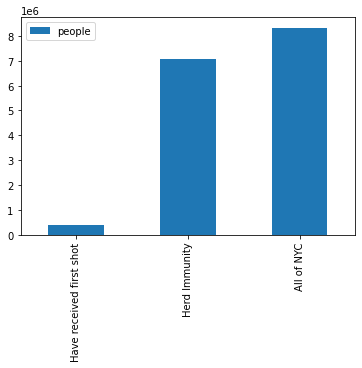

In [8]:
first_shots = vax_nyc.sum()['Dose 1 daily']

perc_of_pop = first_shots / NYC_2019_POP
pop_pretty = f'{perc_of_pop:.2%}'

display(Markdown(f'### {pop_pretty} of NYC has received the first dose'))

df = pd.DataFrame(
    [first_shots, NYC_VACCINATION_NUMBER, NYC_2019_POP], 
    index=['Have received first shot', 'Herd Immunity', 'All of NYC'], 
    columns=['people'])
df.plot.bar()


# How quickly are we vaccinating?

<AxesSubplot:title={'center':'Total vaccinated per week'}, xlabel='Week Start'>

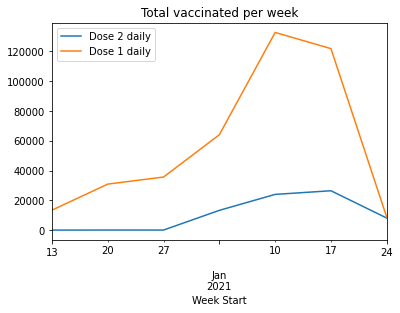

In [9]:
vax_nyc_weekly.plot(x='Week Start', title='Total vaccinated per week')

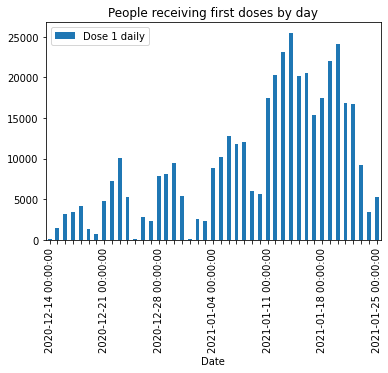

In [10]:
ax = vax_nyc.plot.bar(x='Date', y='Dose 1 daily', title='People receiving first doses by day')
for i, t in enumerate(ax.get_xticklabels()):
    if i % 7:
        t.set_visible(False)


# How long until we reach immunity?

In [13]:
avg_last_7 = vax_nyc.sort_values('Date').tail(7).mean(numeric_only=True)['Dose 1 daily']
avg_prev_7 = vax_nyc.sort_values('Date').tail(14).head(7).mean(numeric_only=True)['Dose 1 daily']

# growth = avg_last_7 - avg_prev_7

## 2021-01-24 - can't calculate. Growth is negative. 
# weeks = 0
# this_week = avg_last_7
# while this_week <= NYC_VACCINATION_NUMBER:
#     weeks += 1
#     this_week += growth

# Markdown(f'### It will take _{weeks:,}_ weeks to vaccinate enough people, based on current linear growth rates')

In [14]:
avg_last_7

13936.714285714286

In [15]:
avg_prev_7

20343.85714285714